# Processing Time Series (GEE and XArray)

## **Overview**

This is a demonstration of how we can use the [XEE](https://github.com/google/Xee) package to extract time-series images from Earth Engine and then use XArray to apply smoothing and interpolation and save the processed images as GeoTIFF files locally.


## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install --upgrade xee
    !pip install rioxarray


In [ ]:
import ee
import xarray
import rioxarray as rxr
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import numpy as np

In [ ]:
output_folder = 'output'

if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [ ]:
ee.Authenticate()

In [ ]:
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

We start with the MODIS Vegetation Indices Version 6.1 data. We pre-process the data by applying cloud masking and pixel scaling.

In [ ]:
modis = ee.ImageCollection('MODIS/061/MOD13Q1')

startDate = ee.Date.fromYMD(2020, 1, 1)
endDate = startDate.advance(2, 'year')
filtered = modis.filter(ee.Filter.date(startDate, endDate))

# Cloud Masking
def bitwiseExtract(input, fromBit, toBit):
  maskSize = ee.Number(1).add(toBit).subtract(fromBit)
  mask = ee.Number(1).leftShift(maskSize).subtract(1)
  return input.rightShift(fromBit).bitwiseAnd(mask)

def maskSnowAndClouds(image):
  summaryQa = image.select('SummaryQA')
  # Select pixels which are less than or equals to 1 (0 or 1)
  qaMask = bitwiseExtract(summaryQa, 0, 1).lte(1)
  maskedImage = image.updateMask(qaMask)
  return maskedImage.copyProperties(image, ['system:index', 'system:time_start'])

# MODIS VI values come as VI x 10000 that need to be scaled by 0.0001
def scaleBands(image):
  scaled = image.multiply(0.0001)
  return scaled.copyProperties(image, ['system:index', 'system:time_start'])

# Apply the function to all images in the collection
maskedCol = filtered \
  .map(maskSnowAndClouds) \
  .map(scaleBands)


Now we have an ImageCollection that we want to get it as a XArray Dataset. We define the region of interest and extract the ImageCollection using the 'ee' engine.

In [ ]:
aoi = ee.Geometry.Rectangle(77, 12, 79, 15)

ds = xarray.open_dataset(
    maskedCol,
    engine='ee',
    crs='EPSG:4326',
    scale=0.01,
    geometry=aoi,
)

THe result is a XArray Dataset containing the image time-series.

In [ ]:
ds

Select the 'NDVI' band.

In [ ]:
original_time_series = ds.NDVI
original_time_series

## Interpolate and Smooth the time-series

We use XArray's excellent time-series processing functionality to fill the cloud-masked pixels with linearly interpolated values from temporal neighbors. We also apply a moving-window smoothing to remove noise.

In [ ]:
time_series_interpolated = original_time_series.interpolate_na('time', use_coordinate=False)
time_series_smooth = time_series_interpolated.rolling(time=3, center=True).mean()
time_series_smooth

## Plot and Extract the Time-Series at a Single Location

In [ ]:
original_ts = original_time_series.interp(lat=13.16, lon=77.35)
smooth_ts = time_series_smooth.interp(lat=13.16, lon=77.35)

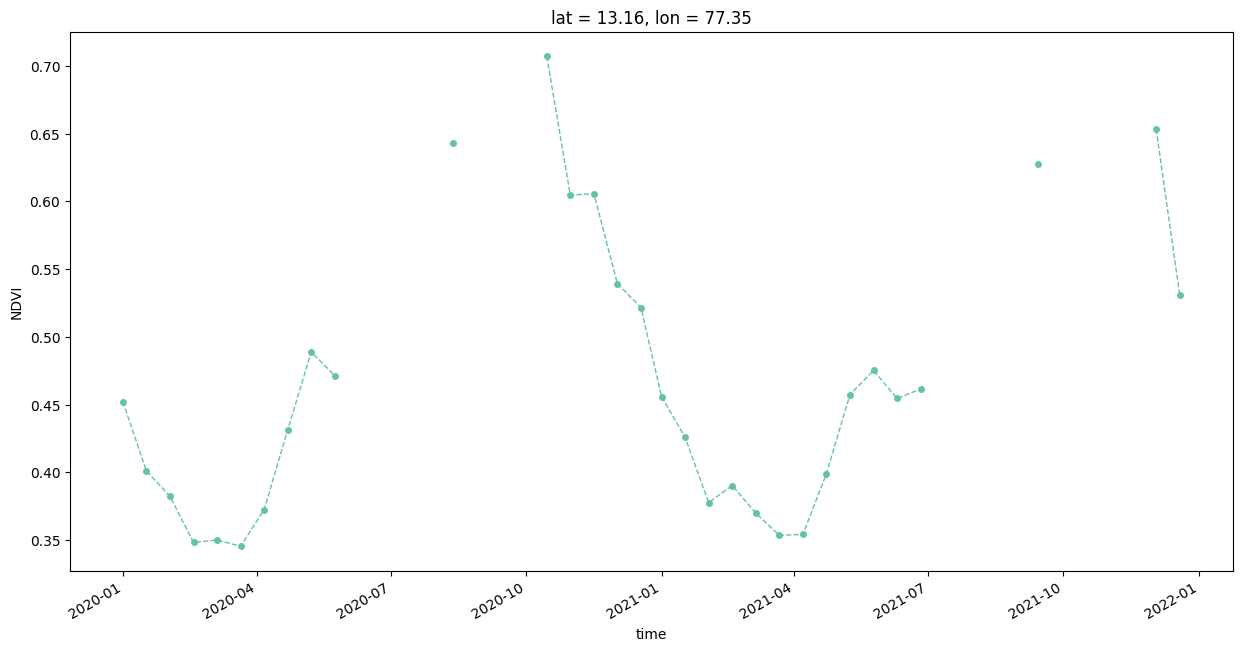

In [227]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
original_ts.plot.line(
    ax=ax, x='time',
    marker='o', color='#66c2a4', linestyle='--', linewidth=1, markersize=4)
plt.show()

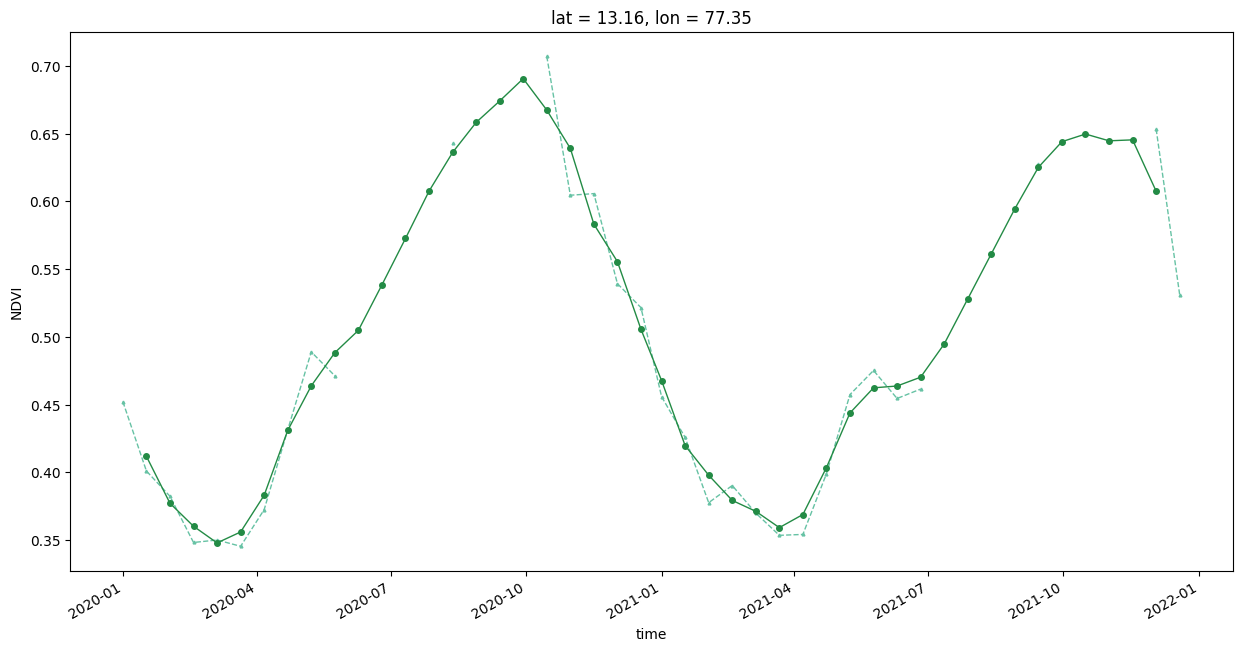

In [228]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
original_ts.plot.line(
    ax=ax, x='time',
    marker='^', color='#66c2a4', linestyle='--', linewidth=1, markersize=2)
smooth_ts.plot.line(
    ax=ax, x='time',
    marker='o', color='#238b45', linestyle='-', linewidth=1, markersize=4)
plt.show()

In [ ]:
df = smooth_ts.to_pandas()
df

In [ ]:
output_filename = 'smoothed_time_series.csv'
output_filepath = os.path.join(output_folder, output_filename)
df.reset_index().to_csv(output_filepath, index=False)

## Download Smoothed Time-Series Images

Save the original time-series images using `rioxarray` as GeoTIFF files.

In [ ]:
for time in original_time_series.time.values:
  image = original_time_series.sel(time=time)
  # transform the image to suit rioxarray format
  image = image \
    .rename({'lat': 'y', 'lon': 'x'}) \
    .transpose('y', 'x') \
    .rio.write_crs('EPSG:4326')

  date = np.datetime_as_string(time, unit='D')
  output_file = f'original_{date}.tif'
  output_path = os.path.join(output_folder, output_file)
  image.rio.to_raster(output_path, driver='COG')

Save the smoothed time-series images.

In [ ]:
for time in time_series_smooth.time.values:
  image = time_series_smooth.sel(time=time)
  # transform the image to suit rioxarray format
  image = image \
    .rename({'lat': 'y', 'lon': 'x'}) \
    .transpose('y', 'x') \
    .rio.write_crs('EPSG:4326')

  date = np.datetime_as_string(time, unit='D')
  output_file = f'smoothed_{date}.tif'
  output_path = os.path.join(output_folder, output_file)
  image.rio.to_raster(output_path, driver='COG')
